This puts all the data from the feature generator, image_ids, and business_ids into a single pandas dataframe and then outputs a pickle file to store the result. Should be 465MB unzipped.

In [4]:
from pathlib2 import PosixPath
import pandas as pd

base_dir = '../data/'

limit = 234842
# uncomment to limit to 10 rows for testing..
#limit = 10

cols = []
feat_dtypes = {
}
images = []
for i in range(1024):
    col = 'f_' + str(i)
    cols.append(col)
    # We only need a float16 for the feature, not a float64 which is pandas default float. 
    # Makes a big difference when saving (1/4 size), but not in memory.
    feat_dtypes[col] = pd.np.float16
    
# Note that you need to use the c engine apparently to get the dypes to work.
features = pd.read_csv(base_dir + 'features_test.txt', delimiter=' ', nrows=limit, 
                       names=cols, index_col=False, engine='c', dtype=feat_dtypes)
biz_ids = pd.read_csv(base_dir + "train_photo_to_biz_ids.csv", delimiter=',', nrows=limit, index_col=False)

img_f = open(base_dir + 'images_test.txt', 'r')

for i in range(len(features)):
    img = PosixPath(img_f.readline())
    i_period = img.name.find('.')
    images.append(int(img.name[:i_period]))

image_ids = pd.DataFrame(images, columns=['photo_id'])

img_f.close()
result = pd.concat([image_ids, features], axis=1, join='outer')
features=None
image_ids=None
img_f=None
images=None
new_result=None
new_result = pd.merge(biz_ids, result, how='left', sort=False, on=['photo_id'])
pd.to_pickle(new_result, base_dir + 'features_test.pickle')

# Test that things work
print result.loc[result['photo_id'] == 113970].f_0
print biz_ids.loc[biz_ids['photo_id'] == 113970].photo_id


0    0.498535
Name: f_0, dtype: float16
Series([], Name: photo_id, dtype: int64)


In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

# Load the cached pandas pickle file.
base_dir = '../data/'
features = pd.read_pickle(base_dir + 'features_test.pickle')


In [52]:
biz_feat = features[['photo_id', 'business_id']].groupby(['business_id']).agg(['count'])

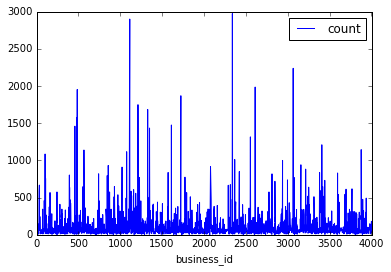

In [61]:
# Numbers of images per business.
biz_feat['photo_id'].plot()

# Looks like there is a lot of variation on the number of images per business.

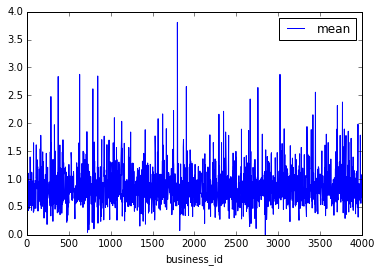

In [68]:
#Looking at the mean across business for feature 0.
biz_feat = features.groupby(['business_id']).agg(['mean'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat['f_0'].plot()


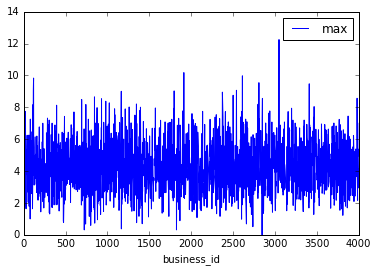

In [69]:
#Looking at the mean across business for feature 0.
biz_feat = features.groupby(['business_id']).agg(['max'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat['f_0'].plot()

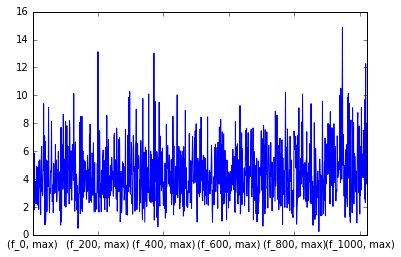

In [14]:
# Show the variance of features for a single business.
biz_feat = features.groupby(['business_id']).agg(['max'])
biz_feat.drop('photo_id', axis=1, inplace=True)
biz_feat.loc[4].plot()